# SparkMeasure with Machine Learning

In [14]:
!pip3 install sparkmeasure

You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.


In [15]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [17]:
import random
import numpy as np
import pandas as pd
from pyspark.mllib.stat import Statistics

In [18]:
# Create Spark Session
# This example uses a local cluster, you can modify master to use  YARN or K8S if available 
# This example downloads sparkMeasure 0.14 for scala 2_11 from maven central

spark = SparkSession \
 .builder \
 .appName("Test sparkmeasure instrumentation of Python/PySpark code") \
 .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
 .config("spark.yarn.access.hadoopFileSystems","s3a://demo-aws-1/")\
 .config("spark.jars.packages","ch.cern.sparkmeasure:spark-measure_2.11:0.14")  \
 .config("spark.executor.instances", 4)\
 .config("spark.executor.cores", 4)\
 .getOrCreate()
 #.master("local[*]") \

In [19]:
# Load the Python API for sparkmeasure package
# and attach the sparkMeasure Listener for stagemetrics to the active Spark session

from sparkmeasure import StageMetrics
stagemetrics = StageMetrics(spark)

In [20]:
# Define cell and line magic to wrap the instrumentation
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)

@register_line_cell_magic
def sparkmeasure(line, cell=None):
    "run and measure spark workload. Use: %sparkmeasure or %%sparkmeasure"
    val = cell if cell is not None else line
    stagemetrics.begin()
    eval(val)
    stagemetrics.end()
    stagemetrics.print_report()

In [21]:
%%sparkmeasure
spark.sql("SELECT acc_now_delinq, is_default FROM default.LC_Table LIMIT 3").show()

+--------------+----------+
|acc_now_delinq|is_default|
+--------------+----------+
|             0|         1|
|             0|         0|
|             0|         0|
+--------------+----------+


Scheduling mode = FIFO
Spark Context default degree of parallelism = 16
Aggregated Spark stage metrics:
numStages => 2
numTasks => 9
elapsedTime => 1750 (2 s)
stageDuration => 1749 (2 s)
executorRunTime => 4028 (4 s)
executorCpuTime => 515 (0.5 s)
executorDeserializeTime => 111 (0.1 s)
executorDeserializeCpuTime => 38 (38 ms)
resultSerializationTime => 0 (0 ms)
jvmGCTime => 7 (7 ms)
shuffleFetchWaitTime => 0 (0 ms)
shuffleWriteTime => 2 (2 ms)
resultSize => 12161 (11.0 KB)
diskBytesSpilled => 0 (0 Bytes)
memoryBytesSpilled => 0 (0 Bytes)
peakExecutionMemory => 0
recordsRead => 421096
bytesRead => 300748 (293.0 KB)
recordsWritten => 0
bytesWritten => 0 (0 Bytes)
shuffleRecordsRead => 0
shuffleTotalBlocksFetched => 0
shuffleLocalBlocksFetched => 0
shuffleRemoteBlocksFetched => 0
shuffleTotalBy

In [22]:
!rm -R /tmp/stagemetrics*

stagemetrics.begin()

spark.sql("SELECT acc_now_delinq, is_default FROM default.LC_Table LIMIT 3")

df = spark.sql("SELECT * FROM default.LC_Table")
df = df.select(['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt', 'is_default'])
df = df.dropna()

df.show()

met_df = stagemetrics.create_stagemetrics_DF("PerfStageMetrics")
stagemetrics.save_data(met_df.orderBy("jobId","stageId"), "/tmp/stagemetrics_test1")

#agg_met_df = stagemetrics.aggregate_stagemetrics_DF("PerfStageMetrics")
#stagemetrics.save_data(met_df.orderBy(agg_met_df, "/tmp/agg_stagemetrics_test1"))

stagemetrics.end()
stagemetrics.print_report()

+--------------+--------------------+----------+-----------+-----------+----------+
|acc_now_delinq|acc_open_past_24mths|annual_inc|avg_cur_bal|funded_amnt|is_default|
+--------------+--------------------+----------+-----------+-----------+----------+
|             0|                   5|   84000.0|      24466|      15000|         1|
|             0|                   4|   65000.0|      48343|      15000|         0|
|             0|                  10|   98000.0|       9896|       7000|         0|
|             0|                  14|   80000.0|       8689|      15000|         1|
|             0|                   4|   65000.0|       1259|       9000|         1|
|             0|                   3|   56000.0|       2143|      18500|         0|
|             0|                   5|   30000.0|       2924|       3500|         0|
|             0|                   4|   75000.0|      12217|      18500|         0|
|             0|                   1|   59000.0|       8357|       2275|    

In [23]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df):        
     
    for c in spark_df.columns:
        spark_df = spark_df.withColumn(c, spark_df[c].cast("float"))
    
    stages= []

    cols = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt']
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    stages += [assembler]    
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]
    
    #Logistic Regression
    lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='is_default', maxIter=10, regParam=0.3, elasticNetParam=0.4)
    stages += [lr]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)
    out_df = pipelineModel.transform(spark_df)
    
    return out_df, pipelineModel

In [24]:
from sparkmeasure import TaskMetrics
taskmetrics = TaskMetrics(spark)

In [61]:
!rm -R /tmp/taskmetrics_test1

taskmetrics.begin()
df_model, pipelineModel = make_pipeline(df)

task_df = taskmetrics.create_taskmetrics_DF("PerfTaskMetrics")
taskmetrics.save_data(task_df.orderBy("jobId","stageId"), "/tmp/taskmetrics_test1", "json")

#agg_met_df = stagemetrics.aggregate_stagemetrics_DF("PerfStageMetrics")
#stagemetrics.save_data(met_df.orderBy(agg_met_df, "/tmp/agg_stagemetrics_test1"))

taskmetrics.end()
taskmetrics.print_report()


Scheduling mode = FIFO
Spark Contex default degree of parallelism = 16
Aggregated Spark task metrics:
numtasks => 70
elapsedTime => 1829 (2 s)
duration => 7642 (8 s)
schedulerDelayTime => 255 (0.3 s)
executorRunTime => 6834 (7 s)
executorCpuTime => 2825 (3 s)
executorDeserializeTime => 552 (0.6 s)
executorDeserializeCpuTime => 126 (0.1 s)
resultSerializationTime => 1 (1 ms)
jvmGCTime => 389 (0.4 s)
shuffleFetchWaitTime => 6 (6 ms)
shuffleWriteTime => 0 (0 ms)
gettingResultTime => 0 (0 ms)
resultSize => 3341 (3.0 KB)
diskBytesSpilled => 0 (0 Bytes)
memoryBytesSpilled => 0 (0 Bytes)
peakExecutionMemory => 4259840
recordsRead => 1263286
bytesRead => 106131100 (101.0 MB)
recordsWritten => 30
bytesWritten => 26240 (25.0 KB)
shuffleRecordsRead => 84
shuffleTotalBlocksFetched => 48
shuffleLocalBlocksFetched => 20
shuffleRemoteBlocksFetched => 28
shuffleTotalBytesRead => 29986 (29.0 KB)
shuffleLocalBytesRead => 13823 (13.0 KB)
shuffleRemoteBytesRead => 16163 (15.0 KB)
shuffleRemoteBytesReadTo

In [62]:
taskmetrics.begin()
input_data = df_model.rdd.map(lambda x: (x["is_default"], float(x['probability'][1])))
taskmetrics.end()
taskmetrics.print_report()
#taskmetrics.save_data(task_df.orderBy("jobId","stageId"), "/tmp/taskmetrics_test2", "json")


Scheduling mode = FIFO
Spark Contex default degree of parallelism = 16
Aggregated Spark task metrics:
numtasks => 0
elapsedTime => null
duration => null
schedulerDelayTime => null
executorRunTime => null
executorCpuTime => null
executorDeserializeTime => null
executorDeserializeCpuTime => null
resultSerializationTime => null
jvmGCTime => null
shuffleFetchWaitTime => null
shuffleWriteTime => null
gettingResultTime => null
resultSize => null
diskBytesSpilled => null
memoryBytesSpilled => null
peakExecutionMemory => null
recordsRead => null
bytesRead => null
recordsWritten => null
bytesWritten => null
shuffleRecordsRead => null
shuffleTotalBlocksFetched => null
shuffleLocalBlocksFetched => null
shuffleRemoteBlocksFetched => null
shuffleTotalBytesRead => null
shuffleLocalBytesRead => null
shuffleRemoteBytesRead => null
shuffleRemoteBytesReadToDisk => null
shuffleBytesWritten => null
shuffleRecordsWritten => null


In [63]:
taskmetrics.begin()
predictions = spark.createDataFrame(input_data, ["is_default", "probability"])
taskmetrics.end()
taskmetrics.print_report()
#taskmetrics.save_data(task_df.orderBy("jobId","stageId"), "/tmp/taskmetrics_test3", "json")


Scheduling mode = FIFO
Spark Contex default degree of parallelism = 16
Aggregated Spark task metrics:
numtasks => 1
elapsedTime => 494 (0.5 s)
duration => 494 (0.5 s)
schedulerDelayTime => 5 (5 ms)
executorRunTime => 480 (0.5 s)
executorCpuTime => 3 (3 ms)
executorDeserializeTime => 9 (9 ms)
executorDeserializeCpuTime => 3 (3 ms)
resultSerializationTime => 0 (0 ms)
jvmGCTime => 36 (36 ms)
shuffleFetchWaitTime => 0 (0 ms)
shuffleWriteTime => 0 (0 ms)
gettingResultTime => 0 (0 ms)
resultSize => 2043 (2043 Bytes)
diskBytesSpilled => 0 (0 Bytes)
memoryBytesSpilled => 0 (0 Bytes)
peakExecutionMemory => 0
recordsRead => 16384
bytesRead => 3914094 (3.0 MB)
recordsWritten => 0
bytesWritten => 0 (0 Bytes)
shuffleRecordsRead => 0
shuffleTotalBlocksFetched => 0
shuffleLocalBlocksFetched => 0
shuffleRemoteBlocksFetched => 0
shuffleTotalBytesRead => 0 (0 Bytes)
shuffleLocalBytesRead => 0 (0 Bytes)
shuffleRemoteBytesRead => 0 (0 Bytes)
shuffleRemoteBytesReadToDisk => 0 (0 Bytes)
shuffleBytesWritten

In [64]:
#Saving pipeline to S3:
#pipelineModel.write().overwrite().save("s3a://demo-aws-1/datalake/pdefusco/pipeline")

Read Metrics

In [65]:
df_stage_metrics = spark.sql("select * from PerfStageMetrics")

In [66]:
df_stage_metrics.columns

['jobId',
 'jobGroup',
 'stageId',
 'name',
 'submissionTime',
 'completionTime',
 'stageDuration',
 'numTasks',
 'executorRunTime',
 'executorCpuTime',
 'executorDeserializeTime',
 'executorDeserializeCpuTime',
 'resultSerializationTime',
 'jvmGCTime',
 'resultSize',
 'diskBytesSpilled',
 'memoryBytesSpilled',
 'peakExecutionMemory',
 'recordsRead',
 'bytesRead',
 'recordsWritten',
 'bytesWritten',
 'shuffleFetchWaitTime',
 'shuffleTotalBytesRead',
 'shuffleTotalBlocksFetched',
 'shuffleLocalBlocksFetched',
 'shuffleRemoteBlocksFetched',
 'shuffleLocalBytesRead',
 'shuffleRemoteBytesRead',
 'shuffleRemoteBytesReadToDisk',
 'shuffleRecordsRead',
 'shuffleWriteTime',
 'shuffleBytesWritten',
 'shuffleRecordsWritten']

In [67]:
df_task_metrics = spark.sql("select * from PerfTaskMetrics")

In [68]:
df_task_metrics.columns

['jobId',
 'jobGroup',
 'stageId',
 'index',
 'launchTime',
 'finishTime',
 'duration',
 'schedulerDelay',
 'executorId',
 'host',
 'taskLocality',
 'speculative',
 'gettingResultTime',
 'successful',
 'executorRunTime',
 'executorCpuTime',
 'executorDeserializeTime',
 'executorDeserializeCpuTime',
 'resultSerializationTime',
 'jvmGCTime',
 'resultSize',
 'diskBytesSpilled',
 'memoryBytesSpilled',
 'peakExecutionMemory',
 'recordsRead',
 'bytesRead',
 'recordsWritten',
 'bytesWritten',
 'shuffleFetchWaitTime',
 'shuffleTotalBytesRead',
 'shuffleTotalBlocksFetched',
 'shuffleLocalBlocksFetched',
 'shuffleRemoteBlocksFetched',
 'shuffleLocalBytesRead',
 'shuffleRemoteBytesRead',
 'shuffleRemoteBytesReadToDisk',
 'shuffleRecordsRead',
 'shuffleWriteTime',
 'shuffleBytesWritten',
 'shuffleRecordsWritten']

In [69]:
stages_report = spark.sql("SELECT * FROM PerfStageMetrics").toPandas().transpose()
stages_report

,0,1,2,3,4
jobId,10,11,12,12,12
jobGroup,None,None,None,None,None
stageId,19,20,21,22,23
name,showString at NativeMethodAccessorImpl.java:0,save at NativeMethodAccessorImpl.java:0,save at NativeMethodAccessorImpl.java:0,save at NativeMethodAccessorImpl.java:0,save at NativeMethodAccessorImpl.java:0
submissionTime,1599708230235,1599708230690,1599708230748,1599708230793,1599708230878
completionTime,1599708230564,1599708230721,1599708230793,1599708230878,1599708231023
stageDuration,329,31,45,85,145
numTasks,1,1,1,1,1
executorRunTime,312,3,2,54,72
executorCpuTime,71,2,2,51,50


In [70]:
# Prints the aggregated values of the metrics using Pandas to display as HTML table
# this notebook was tested using Anaconda, so among others Pandas are imported by default
# Note that the metrics referring to time measurements are in millisecond

report = spark.sql("""
select count(*) numtasks, max(finishTime) - min(launchTime) as elapsedTime, sum(duration), sum(schedulerDelay),
       sum(executorRunTime), sum(executorCpuTime), sum(executorDeserializeTime), sum(executorDeserializeCpuTime),
       sum(resultSerializationTime), sum(jvmGCTime), sum(shuffleFetchWaitTime), sum(shuffleWriteTime), sum(gettingResultTime),
       max(resultSize), sum(diskBytesSpilled), sum(memoryBytesSpilled), 
       max(peakExecutionMemory), sum(recordsRead), sum(bytesRead), sum(recordsWritten), sum(bytesWritten),
       sum(shuffleTotalBytesRead), sum(shuffleTotalBlocksFetched), sum(shuffleLocalBlocksFetched), 
       sum(shuffleRemoteBlocksFetched), sum(shuffleBytesWritten), sum(shuffleRecordsWritten) 
       from PerfTaskMetrics
""").toPandas().transpose()

report.columns=['Metric value']
report

,Metric value
numtasks,1
elapsedTime,494
sum(duration),494
sum(schedulerDelay),5
sum(executorRunTime),480
sum(executorCpuTime),3
sum(executorDeserializeTime),9
sum(executorDeserializeCpuTime),3
sum(resultSerializationTime),0
sum(jvmGCTime),36


In [92]:
max_finish_time = spark.sql("select max(completionTime), min(submissionTime) from PerfStageMetrics").collect()[0][0]
min_launch_time = spark.sql("select max(completionTime), min(submissionTime) from PerfStageMetrics").collect()[0][1]

In [96]:
# Define the reference time range samples, as equispaced time intervals from begin_time and end_time
# define a temporary view hich will be used in the following SQL
# currently the time interval is hardcoded to 1 sec (= 1000 ms = 10^3 ms)

spark.sql("select id as time, int((id - {0})/1000) as time_normalized from range({0}, {1}, 1000)".
          format(round(max_finish_time,-3), round(min_launch_time,-3))).createOrReplaceTempView("TimeRange")

In [99]:
# For each reference time value taken from TimeRange, list the number of running tasks
# the output is a temporary view ConcurrentRunningTasks
#
spark.sql("""
select TimeRange.time_normalized as time, PTM.*
from TimeRange left outer join PerfStageMetrics PTM 
where TimeRange.time between PTM.submissionTime and PTM.completionTime
order by TimeRange.time_normalized
""").createOrReplaceTempView("ConcurrentRunningTasks")

In [100]:
plot_num_running_tasks = spark.sql("""
select time, count(*) num_running_tasks 
from ConcurrentRunningTasks 
group by time
order by time
""").toPandas()

In [101]:
plot_num_running_tasks

,time,num_running_tasks


In [85]:
ax = plot_num_running_tasks.plot(x='time', y='num_running_tasks', linestyle='solid', linewidth=4, figsize=(12, 8))
ax.set_title("Number of running Spark tasks vs. Time", fontsize=24)
ax.set_xlabel("Time (sec)", fontsize=18)
ax.set_ylabel("Number of tasks running concurrently at a given time", fontsize=18)

plt.show()

TypeError: no numeric data to plot

In [86]:
# load into Pandas the values of number of concurrent running tasks per host and time sample
# see also the heatmap visualization in the next cell

plot_heatmap_running_tasks_per_host = spark.sql("""
select time, host, count(*) num_running_tasks 
from ConcurrentRunningTasks 
group by time, host
order by time, host
""").toPandas()

pivoted_heatmapPandas = plot_heatmap_running_tasks_per_host.pivot(index='time', columns='host', values='num_running_tasks')

In [87]:
# plot heatmap
plt.figure(figsize=(16, 10))
ax = sns.heatmap(pivoted_heatmapPandas.T, cmap="YlGnBu", xticklabels=10)

ax.set_title("Heatmap: Number of concurrent tasks vs. Host name and Time", fontsize=24)
ax.set_xlabel("Time (sec)", fontsize=18)
ax.set_ylabel("Host name", fontsize=18)
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 1152x720 with 0 Axes>

In [ ]:
spark.sql("""
select host, min(duration), round(avg(duration),0), max(duration), sum(duration), count(*) num_tasks 
from PerfTaskMetrics 
group by host
order by 3 desc
""").show()

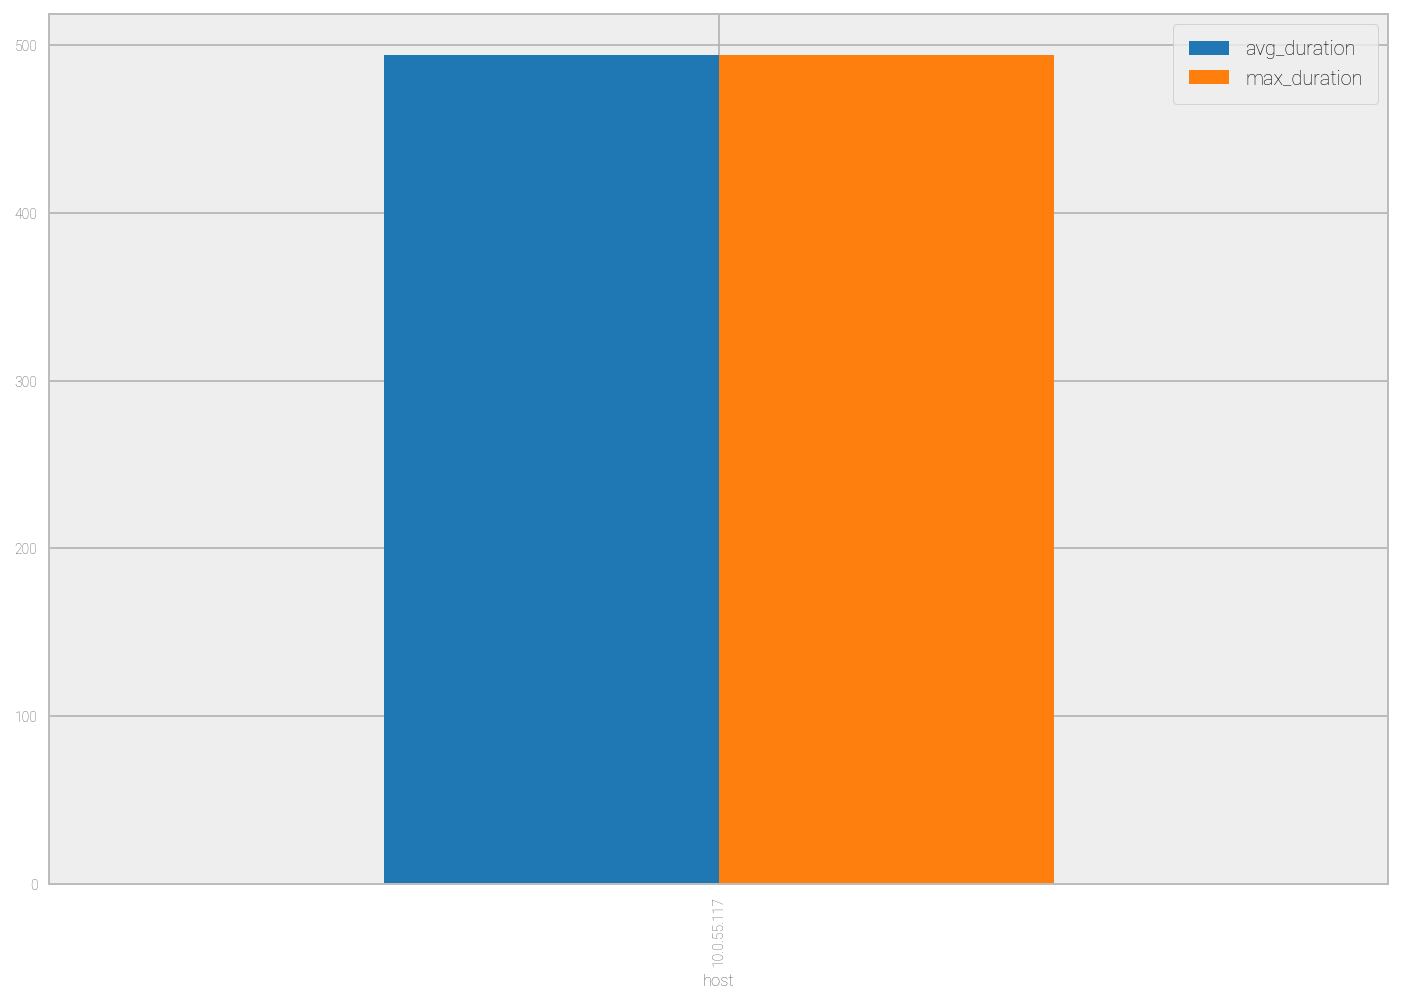

In [88]:
spark.sql("""
select host, avg(duration) avg_duration, max(duration) max_duration
from PerfTaskMetrics 
group by host""").toPandas().plot(x='host', kind='bar', figsize=(12, 8))

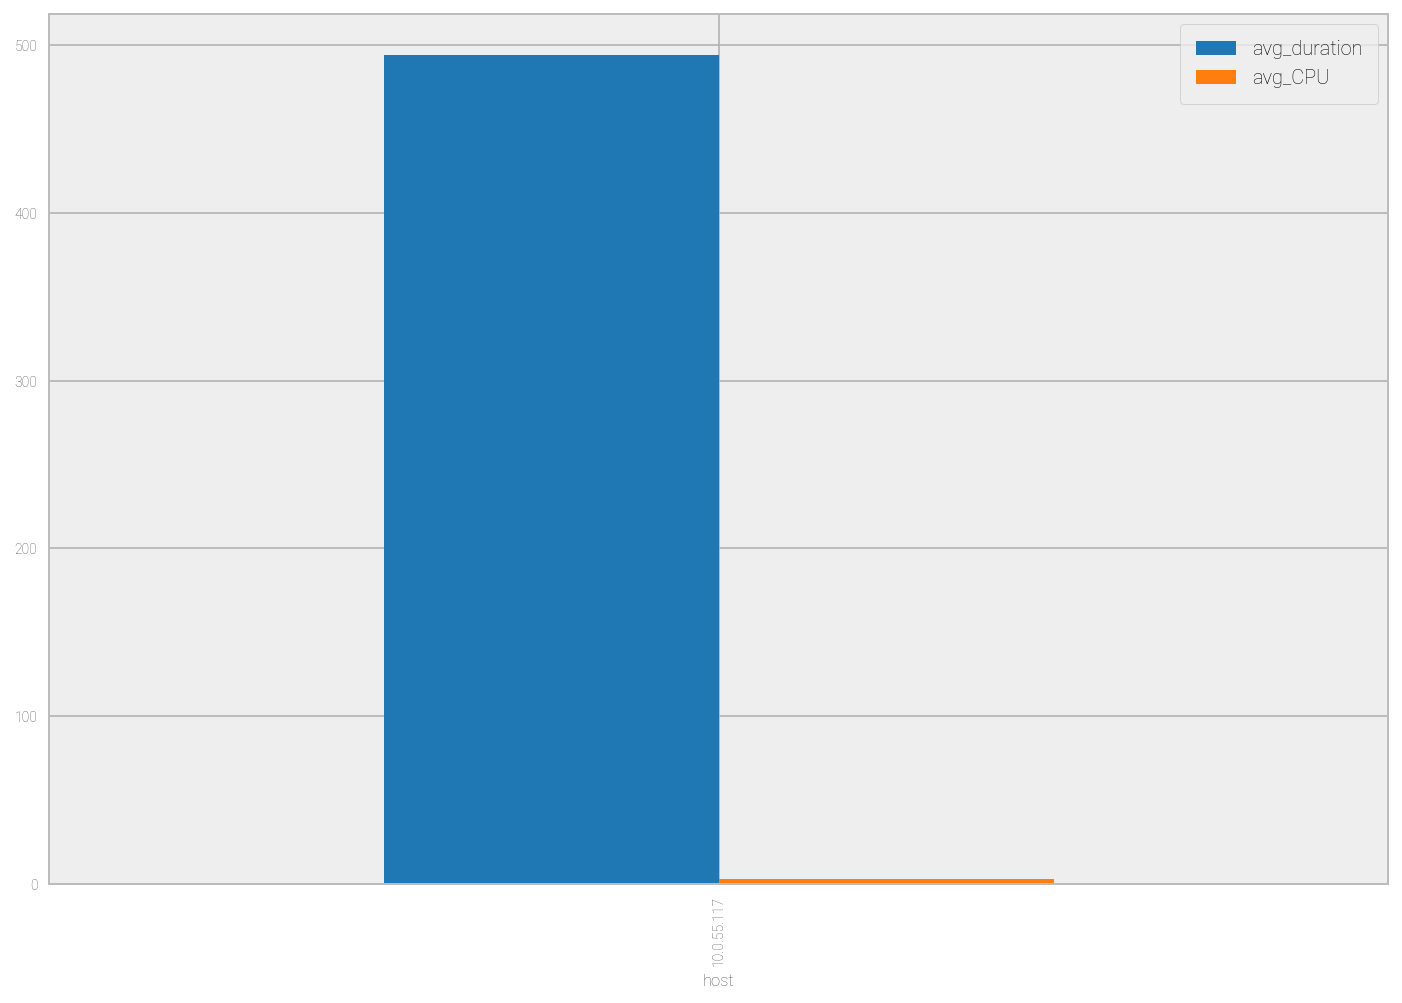

In [89]:
spark.sql("""
select host, avg(duration) avg_duration, avg(executorCpuTime) avg_CPU
from PerfTaskMetrics 
group by host""").toPandas().plot(x='host', kind='bar', figsize=(12, 8))

In [90]:
#spark.stop()